In [0]:
import requests
import json
import pandas as pd
zones = requests.get("https://api.covid19india.org/zones.json")
data = json.loads(zones.text)
dist_zone={}
for entry in data['zones']:
  # dist_zone_list.append([entry['district'],entry['state'],entry['zone']])
  dist_zone.update({entry['district']:entry['zone']})

districts = requests.get("https://api.covid19india.org/districts_daily.json")
data_district = json.loads(districts.text)
data_cnt=[]
from datetime import datetime
def getCaseAndLastReport(jsonObjectParam):
    cases_dist=pd.DataFrame(jsonObjectParam)
    current=cases_dist.max()
    current_cnf_cnt=current.confirmed
    current_dt=current.date
    previous=cases_dist[cases_dist['confirmed']<current_cnf_cnt].max()
    previous_cnf_cnt=previous.confirmed
    previous_dt=previous.date
    if(pd.isnull(previous_dt)):
      previous_dt='2020-04-21'
    datetime1=datetime.strptime(current_dt,'%Y-%m-%d')
    datetime2=datetime.strptime(previous_dt,'%Y-%m-%d')
    diff=(datetime1-datetime2).days
    return [diff,current_cnf_cnt]

In [0]:
for state in data_district['districtsDaily']:
  for district in data_district['districtsDaily'][state]:
    info=[state,district]
    val=getCaseAndLastReport(data_district['districtsDaily'][state][district])
    data_cnt.append(info+val)

In [0]:
district_df=pd.DataFrame(data_cnt,columns=['State','District','DaysOfNoChange','Count'])
district_df['zone']=district_df['District'].map(dist_zone)

In [0]:
district_df.dropna(inplace=True)

In [7]:
district_df

,State,District,DaysOfNoChange,Count,zone
0,Andaman and Nicobar Islands,North and Middle Andaman,33,1,Green
1,Andaman and Nicobar Islands,South Andaman,30,32,Red
3,Andaman and Nicobar Islands,Nicobars,33,0,Green
4,Andhra Pradesh,Anantapur,5,136,Orange
5,Andhra Pradesh,Chittoor,5,208,Red
...,...,...,...,...,...
824,Nagaland,Zunheboto,33,0,Green
825,Sikkim,East District,33,0,Green
826,Sikkim,North District,33,0,Green
827,Sikkim,South District,33,0,Green


In [0]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
zoneTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
zoneTree # it shows the default parameters

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
X=district_df[['DaysOfNoChange','Count']].values
y = district_df['zone'].values

In [0]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

In [0]:
zoneTree.fit(X_trainset,y_trainset)
predTree = zoneTree.predict(X_testset)

In [55]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.7432432432432432


In [0]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
import numpy as np
%matplotlib inline 

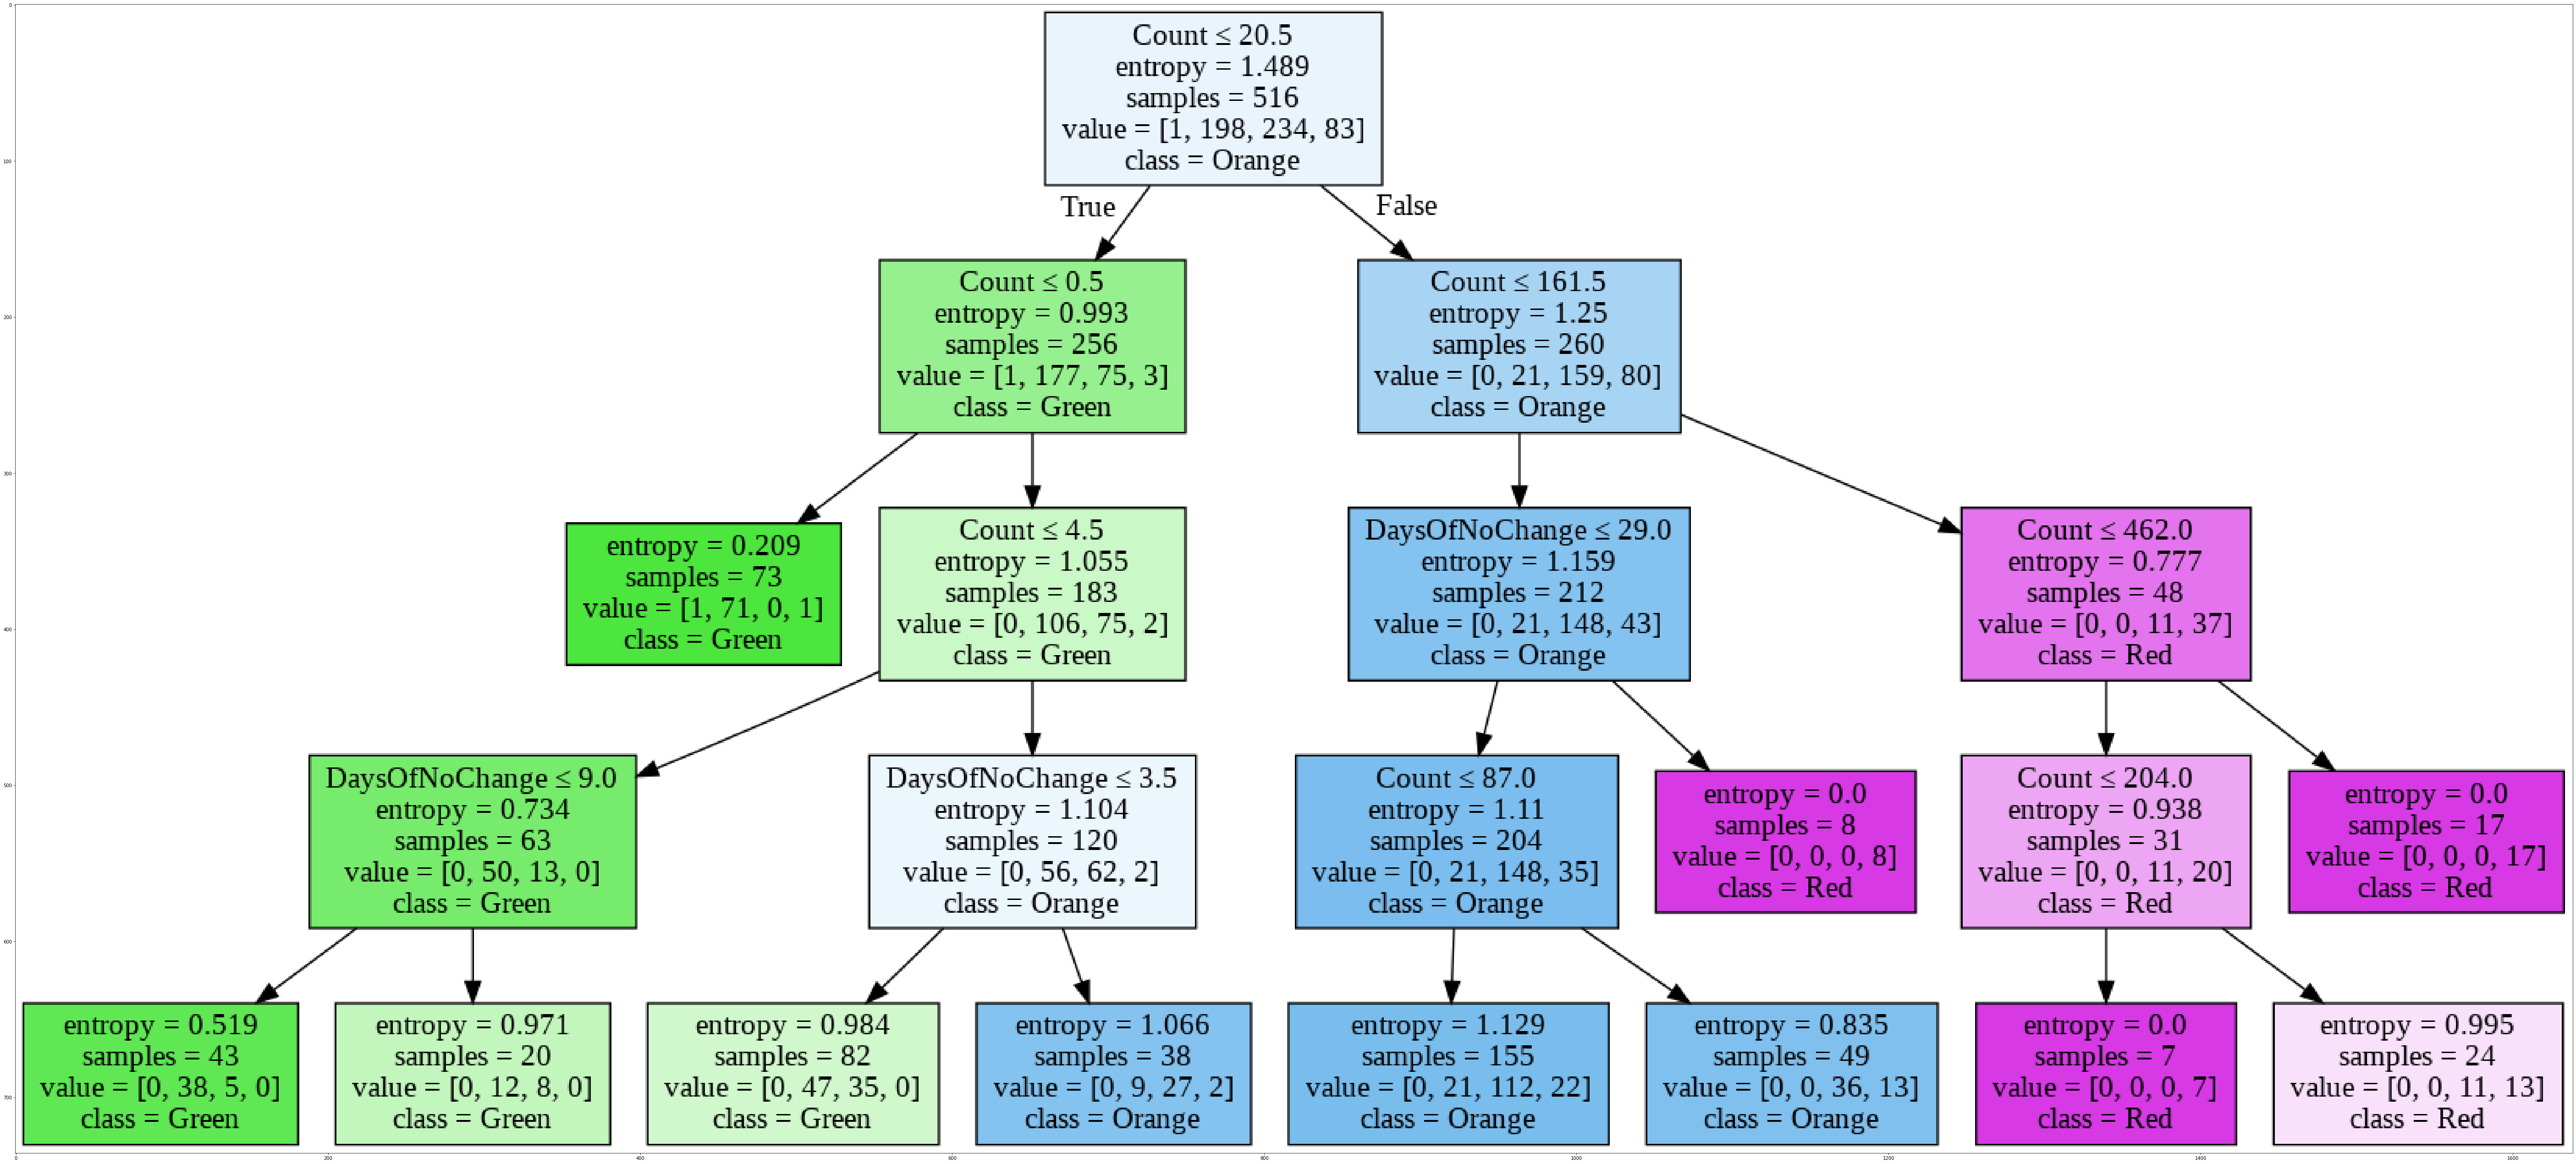

In [61]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = district_df.columns[2:4]
targetNames = district_df["zone"].unique().tolist()
out=tree.export_graphviz(zoneTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

Predict a new input with case count currently of 90 and past case reported 2 days back

In [69]:
x_new=np.array([
                [2,90]
])
predTree = zoneTree.predict(x_new)
predTree

array(['Orange'], dtype=object)